# Look for generalisation


Check whether animals learn the inferrable line or loop transitions faster than the novel transitions. An obvious problem with this is that they also have to unlearn one of the transitions. Is there a way around this?? 
Surely, the way around this is that the difference between the structure and non-structure transition increases over time.

How do you quantify how they are learning it?






In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
import traceback
from statsmodels.stats import proportion
from scipy.ndimage import gaussian_filter1d
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import networkx as nx
sys.path.append("/Users/Yves/Documents/Code/structural_knowledge/packages/")
sys.path.append("/Users/Yves/Documents/Code/")

clrs = seaborn.color_palette()
clrs2 = ['r','g','b']


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import mouse_poker as mpk
import yutils

# Defined functions 

In [3]:
poke_pos = [  [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [4]:
def get_empty_transition_dict(n_nodes=9):
    tmp1 = [str(i[1])+str(i[-2]) for i in list(itertools.combinations(range(n_nodes+1),2))]
    tmp1.extend([i[::-1] for i in tmp1])
    res_dct = {}
    for i in tmp1:
        res_dct[i] = []
    return res_dct

In [161]:
def classify_transitions(session_transitions,structure):
    initial_set = session_transitions[0].copy()
    obs_set = initial_set
    
    in_struc_trans = []; out_of_struc_trans = []
    for st_ in session_transitions:
        
        new = [i for i in st_ if i not in obs_set]
        if new:
            #print(new)
            for newT in new:
                #print(newT)
                #if structure=='line':
                if any([newT[0] in i for i in obs_set]):  #if the first entry is one of the existing nodes
                    out_of_struc_trans.append(newT)
                else:
                    in_struc_trans.append(newT)
                #elif structure == 'loop':
                #    pass

                #else:
                #    raise
            
            obs_set.extend(new)
            
    return in_struc_trans, out_of_struc_trans

In [125]:
dat_dict['port'][2][-1]==0

True

In [126]:
dat_dict['port'][2]

[2, 7, 3.148, False]

In [127]:
def process_probe_trials(dat_dict,window_s,res_dict):
    """
        This function returns binary lists for successful completion of probe trials
        the output data are organised by state transition
    """

    isProbe = np.array([i[-1] for i in dat_dict['port']])==0

    poked_in_probe = []
    poked_correct = []
    poked_correctR = []
    poked_correctNR = []

    probe_ixs = np.where(isProbe)[0]

    #for each probe trial
    for ix in np.where(isProbe)[0]:
        t_str = str(dat_dict['state'][ix][0]) + str(dat_dict['state'][ix][1][0])  #from-to
        if t_str not in res_dict.keys():
            res_dict[t_str] = []
        probeT = int(dat_dict['port'][ix][-2]*bin_mult)

        prevPk = dat_dict['port'][ix][0]
        target = dat_dict['port'][ix][1]

        #these are pokes in window before light comes on
        ixs = (np.where((inPoke_t>probeT) *
                       (inPoke_t<(probeT+(window_s*bin_mult))))[0])# *

        #if there are any pokes
        if len(ixs)>0:

            use2 = [i for i in inPokes[ixs] if i!=prevPk]  #ignore repeated pokes at the same port.
            if len(use2)>0:
                if target==use2[0]:
                    res_dict[t_str].append(1)
                else:
                    res_dict[t_str].append(0)
            else:

                res_dict[t_str].append(0)

        else:
            res_dict[t_str].append(0)

    return res_dict

In [128]:
def get_first_above_50(res_dict,inout):
    ress = []
    for kk,i in enumerate(inout):
        dat_ = np.array(res_dict[i]).astype('float')
        dat2_ = gaussian_filter1d(dat_,20,mode='constant',cval=(1/9.))
        #ld2 = len(dat_); l2 = int(np.floor(ld2/10.)*10)
        #dat2_ = dat_[:l2].reshape(-1,10).mean(axis=1)
        
        if len(np.where(dat2_>.4)[0])>0:
            ress.append(np.min(np.where(dat2_>.4)[0]))
        else:
            ress.append(len(dat2_))
    return ress


In [129]:
stt.binom_test(8,20,p=1/9.)

0.000849058404641854

# Actual code to run stuff 

In [130]:
#ROOT = "/Users/yves/Documents/behavior_data/line_loop_cohort_1/"
#ROOT = "/Users/yves/Documents/behavior_data/line_loop_cohort_2/"
ROOT = "/Users/yves/Documents/behavior_data/line_loop_cohort_3/"

#bb  = mpk.load.create_base_df(ROOT,rerun=True)
bb = mpk.load.load_df(ROOT)

In [131]:
good_df = bb.loc[bb['nRews']>20]

In [132]:
allR_dict_1 = dict([(i+'_1',get_empty_transition_dict()) for i in np.unique(good_df['mouse_ID']).tolist()])
allR_dict_2 = dict([(i+'_2',get_empty_transition_dict()) for i in np.unique(good_df['mouse_ID']).tolist()])
allR_dict = {**allR_dict_1, **allR_dict_2}


In [133]:
mouseIDs = np.unique(bb['mouse_ID'])

In [134]:
ix = 0
df2 = bb.loc[bb['mouse_ID']==mouseIDs[ix]]

In [135]:
np.any([np.sum(df2['task_nr'].values==2)<20,np.sum(df2['task_nr'].values==1)<20])

False

In [136]:
keyF = lambda x: float(str(x).replace(' ','').replace('-','').replace('T','').replace(':',''))

In [137]:
len(mouseIDs)

18

In [181]:
res1 = []
res2 = []

res3 = []; res4 = []
new_trans = []
for mIx in range(1,2):#len(mouseIDs)):

    df2 = bb.loc[bb['mouse_ID']==mouseIDs[mIx]]
    print(mIx)
    bin_ms = 1
    THRESHT = 20.
    bin_mult = 1000/bin_ms

    res_dict = {}#get_empty_transition_dict()
    session_transitions = []


    mDF_srt = df2.sort_values(by=['date'])

    start = False
    for task_nr in [1]:
        try:
            mDF_srt_tsk = mDF_srt.loc[mDF_srt['task_nr']==task_nr]
            for _,row in list(mDF_srt_tsk.iterrows()):

                #try:
                    fpath = row['filepath']
                    f = open(fpath,'r')

                    lines = f.readlines()
                    dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,None)

                    if nRews>20:
                        out = mpk.load.get_metadata(lines)
                        experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,summary_dict = out

                        sts_ = np.unique([i[0] for i in dat_dict['state']])
                        nStates_ = len(sts_)
                        if nStates_==3:
                            start = True
                        if start:
                            #print(nStates_,sts_)
                            inPokes,inPoke_t,outPoke_t,poke_dur = mpk.proc.get_pokes(events,event_times,bin_mult)

                            inPoke_t = inPoke_t[poke_dur>THRESHT]; inPokes = inPokes[poke_dur>THRESHT]
                            isProbe = np.array([i[-1] for i in dat_dict['port']])

                            structure = row['structure']
                            #print(structure)
                            #if structure=='loop':
                            #    break
                            transitions = np.unique([str(i[0]) + str(i[1][0]) for i in dat_dict['state']]).tolist()

                            if session_transitions:
                                if structure=='line':
                                    if any([i not in transitions for i in session_transitions[0]]):
                                        print("RESET",session_transitions[0],transitions)
                                        res_dict = {}; session_transitions = []
                            res_dict = process_probe_trials(dat_dict,1,res_dict)
                            session_transitions.append(transitions)
                            new_trans.append([in_,out_])
                            #print(transitions)


                    #except:
                    #    pass
            
            #print(session_transitions)
            if structure=='line':
                if session_transitions:
                    st2 = []
                    for s in session_transitions:
                        if not np.any([i not in res_dict.keys() for i in s]):
                            st2.append(s)
                    in_, out_ = classify_transitions(st2,structure)
                    in_ = [i for i in in_ if i in res_dict.keys()]
                    out_ = [i for i in out_ if i in res_dict.keys()]
                    
                    if ((len(in_)==len(out_)) and (len(in_)>0)):  #this only happens if processed correctly
                        res1.append(get_first_above_50(res_dict,in_))
                        res2.append(get_first_above_50(res_dict,out_))
                        res3.append([np.array(res_dict[i]).astype('float') for i in in_])
                        res4.append([np.array(res_dict[i]).astype('float') for i in out_])
                        print(structure)

        except Exception as e:
                #print(e)
                traceback.print_exc() 


1
RESET ['45', '54', '56', '65'] ['23', '32', '34', '43']
line


In [187]:
if session_transitions:
    st2 = []
    for s in session_transitions:
        if not np.any([i not in res_dict.keys() for i in s]):
            st2.append(s)
    in_, out_ = classify_transitions(st2,structure)
    in_ = [i for i in in_ if i in res_dict.keys()]
    out_ = [i for i in out_ if i in res_dict.keys()]
    print(in_,out_)

    if ((len(in_)==len(out_)) and (len(in_)>0)):  #this only happens if processed correctly
        res1.append(get_first_above_50(res_dict,in_))
        res2.append(get_first_above_50(res_dict,out_))
        res3.append([np.array(res_dict[i]).astype('float') for i in in_])
        res4.append([np.array(res_dict[i]).astype('float') for i in out_])
        print(structure)


['54', '12', '65'] ['45', '21', '56']
line


In [186]:
st2

[['23', '32', '34', '43'],
 ['23', '32', '34', '43'],
 ['23', '32', '34', '43'],
 ['23', '32', '34', '43'],
 ['23', '32', '34', '43'],
 ['23', '32', '34', '43', '45', '54'],
 ['23', '32', '34', '43', '45', '54'],
 ['23', '32', '34', '43', '45', '54'],
 ['23', '32', '34', '43', '45', '54'],
 ['12', '21', '23', '32', '34', '43', '45', '54'],
 ['23', '32', '34', '43', '45', '54'],
 ['12', '21', '23', '32', '34', '43', '45', '54'],
 ['12', '21', '23', '32', '34', '43', '45', '54'],
 ['12', '21', '23', '32', '34', '43', '45', '54'],
 ['12', '21', '23', '32', '34', '43', '45', '54', '56', '65'],
 ['12', '21', '23', '32', '34', '43', '45', '54', '56', '65'],
 ['12', '21', '23', '32', '34', '43', '45', '54', '56', '65'],
 ['12', '21', '23', '32', '34', '43', '45', '54', '56', '65'],
 ['12', '21', '23', '32', '34', '43', '45', '54', '56', '65'],
 ['12', '21', '23', '32', '34', '43', '45', '54', '56', '65'],
 ['12', '21', '23', '32', '34', '43', '45', '54', '56', '65'],
 ['12', '21', '23', '32',

In [182]:
a = []

for r in res3:
    tmp = []
    for r_ in r[:3]:
        tmp.append(r_[:500])
    a.append(tmp)

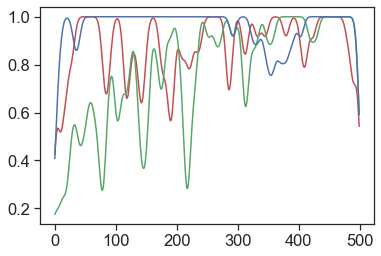

In [188]:
for kk,i in enumerate(np.mean(a,axis=0)):
    plt.plot(gaussian_filter1d(i,5,mode='constant',cval=1/9.),color=clrs2[kk])

(0, 2000)

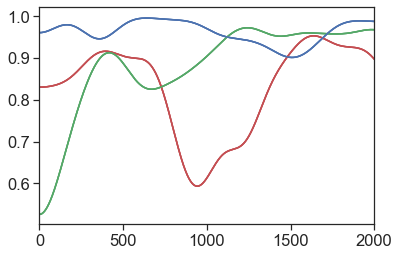

In [190]:
r0s = []
for r in res3:
    for kk,i in enumerate(r[:3]):
        plt.plot(gaussian_filter1d(i,100),color=clrs2[kk])
        #r0s.append(r)
plt.xlim(0,2000)

In [147]:
for kk,i in enumerate(res4[0]):
    plt.plot(gaussian_filter1d(i,5,gaussian_filter1d=),color=clrs2[kk])

SyntaxError: invalid syntax (<ipython-input-147-633c987cf27e>, line 2)

In [148]:
res1_ = [i[:3] for i in res1 if len(i)>=3]

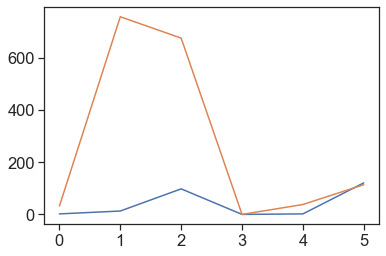

In [150]:
plt.plot(np.mean(np.array([i for i in res1 if len(i)>3])[1:],axis=0))
plt.plot(np.mean(np.array([i for i in res2 if len(i)>3])[1:],axis=0))

In [151]:
np.array([i for i in res1 if len(i)>3])

array([[361, 351,   0,   0, 252,  17],
       [  2,  13,  98,   0,   2, 121]])

In [152]:
stt.ttest_rel(np.array(res1_)[:,1],np.array(res1_)[:,2])

Ttest_relResult(statistic=2.2316499904428064, pvalue=0.04970321522362293)

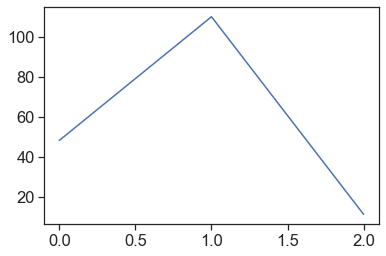

In [153]:
plt.plot(np.mean(np.array(res1_[:-1]),axis=0))
#plt.plot(np.mean(np.array(res2[:-1]),axis=0))

In [154]:
plt.plot(np.mean(np.array(res2),axis=0))

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [155]:
st2 = []
for s in session_transitions:
    if not np.any([i not in res_dict.keys() for i in s]):
        st2.append(s)
in_, out_ = classify_transitions(st2,structure)
in_ = [i for i in in_ if i in res_dict.keys()]
out_ = [i for i in out_ if i in res_dict.keys()]

In [156]:
get_first_above_50(res_dict,in_)

[23, 121, 18, 73, 43, 126]

IndexError: list index out of range

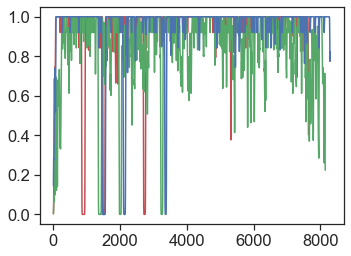

In [157]:
plt.figure(figsize=(12,4))
clrs2 = ['r','g','b']
plt.subplot(1,2,1)
for kk,i in enumerate(in_):
    dat_ = np.array(res_dict[i]).astype('float')
    plt.plot(gaussian_filter1d(dat_,5,mode='nearest'),color=clrs2[kk])
    
plt.subplot(1,2,2)
for kk,i in enumerate(out_):
    dat_ = np.array(res_dict[i]).astype('float')
    plt.plot(gaussian_filter1d(dat_,5,mode='nearest'),color=clrs2[kk])
    
seaborn.despine()

In [160]:
tdict = get_empty_transition_dict()


In [159]:
def classify_transitions(session_transitions,structure):
    initial_set = session_transitions[0].copy()
    obs_set = initial_set
    
    in_struc_trans = []; out_of_struc_trans = []
    for st_ in session_transitions:
        
        new = [i for i in st_ if i not in obs_set]
        if new:
            #print(new)
            for newT in new:
                #print(newT)
                if struc=='line':
                    if any([newT[0] in i for i in obs_set]):  #if the first entry is one of the existing nodes
                        out_of_struc_trans.append(newT)
                    else:
                        in_struc_trans.append(newT)
                elif structure == 'loop':
                    pass

                else:
                    raise
            
            obs_set.extend(new)
            
    return in_struc_trans, out_of_struc_trans

In [131]:
row['structure']

'line'

In [126]:
dat_dict['port']

[[8, 2, 3.586, False],
 [2, 3, 3.936, False],
 [3, 6, 4.41, False],
 [2, 3, 7.869, False],
 [3, 6, 8.486, False],
 [6, 0, 8.849, False],
 [0, 1, 10.658, False],
 [1, 0, 10.885, False],
 [0, 6, 12.728, False],
 [6, 3, 13.037, True],
 [3, 2, 13.243, False],
 [2, 8, 14.08, False],
 [8, 2, 14.475, False],
 [2, 3, 15.442, False],
 [3, 6, 17.024, True],
 [6, 0, 18.855, False],
 [3, 6, 21.932, False],
 [6, 0, 22.297, False],
 [0, 1, 22.705, False],
 [1, 0, 23.238, False],
 [0, 6, 23.45, False],
 [6, 3, 23.909, False],
 [3, 2, 25.449, False],
 [6, 3, 28.516, False],
 [3, 2, 28.925, False],
 [6, 3, 32.407, False],
 [3, 2, 33.005, False],
 [6, 3, 35.721, False],
 [3, 2, 36.026, False],
 [2, 8, 37.677, False],
 [8, 2, 39.15, False],
 [2, 3, 39.446, False],
 [3, 6, 41.607, False],
 [6, 0, 42.055, True],
 [0, 1, 42.405, False],
 [1, 0, 43.274, False],
 [0, 6, 43.614, False],
 [1, 0, 47.742, False],
 [0, 6, 48.745, False],
 [1, 0, 52.387, False],
 [0, 6, 52.709, False],
 [6, 3, 53.095, False],
 [3, 

In [123]:
nPokes

array([5, 5, 7, ..., 2, 2, 7])

In [117]:
#mDF_srt.loc[mDF_srt['task_nr']==1]

In [111]:
row[0]

1482

In [61]:

allRes = []
frac_not_yet = []
frac_not_yet2 = []


tdict = get_empty_transition_dict()


allR_dict_1 = dict([(i+'_1',get_empty_transition_dict()) for i in np.unique(good_df['mouse_ID']).tolist()])
allR_dict_2 = dict([(i+'_2',get_empty_transition_dict()) for i in np.unique(good_df['mouse_ID']).tolist()])
allR_dict = {**allR_dict_1, **allR_dict_2}


allR_dict_1 = dict([(i+'_1',get_empty_transition_dict()) for i in np.unique(good_df['mouse_ID']).tolist()])
allR_dict_2 = dict([(i+'_2',get_empty_transition_dict()) for i in np.unique(good_df['mouse_ID']).tolist()])
allR_dict_lat = {**allR_dict_1, **allR_dict_2}

all_summary_dict= []
for date in np.unique(good_df['date']):
    sys.stdout.write("\r{}".format(date))
    day_df = good_df.loc[good_df['date']==date]
    if True:#'forced' in day_df['task_name'].values[0]:
        

        bin_ms = 1
        bin_mult = 1000/bin_ms


        poked_in_probe = []
        poked_correct = []
        poked_correctR = []
        poked_correctNR = []

        res = {'pkA':[],
               'pkR':[],
               'pkNR':[],
               'pkA2':[],
               'pkR2':[],
               'pkNR2':[],
               'pkFrac': [],
               'pkFR': [],
               'graph_type':[],
               'graph_id':[],
               'task_nr': [],
               'subject_id': []}


        try:
            for fpath in day_df['filepath'].values:
                
                f = open(fpath,'r')

                lines = f.readlines()
                dat_dict,events,event_times,nRews = mpk.load.parse_data(lines,None)
                out = mpk.load.get_metadata(lines)
                experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,summary_dict = out
                all_summary_dict.append(summary_dict)
                
                
                if 'probe_duration' in summary_dict:
                    window_s = 1.#float(summary_dict['probe_duration'])/1000.
                else:
                    window_s  = 1.

                
                res['graph_type'].append(lineloop);res['graph_id'].append(graph);res['task_nr'].append(task_nr)
                res['subject_id'].append(subject_id)

                
                inPokes,inPoke_t,outPoke_t,poke_dur = mpk.proc.get_pokes(events,event_times,bin_mult)

                inPoke_t = inPoke_t[poke_dur>THRESHT]; inPokes = inPokes[poke_dur>THRESHT]
                isProbe = np.array([i[-1] for i in dat_dict['port']])

                poked_in_probe = []
                poked_correct = []
                poked_correctR = []
                poked_correctNR = []

                probe_ixs = np.where(isProbe)[0]
                
                for ix in np.where(isProbe)[0]:
                    t_str = str(dat_dict['port'][ix][0]) + str(dat_dict['port'][ix][1])
                    probeT = int(dat_dict['port'][ix][-2]*bin_mult)

                    prevPk = dat_dict['port'][ix][0]
                    target = dat_dict['port'][ix][1]

                    #these are pokes in window before light comes on
                    ixs = (np.where((inPoke_t>probeT) *
                                   (inPoke_t<(probeT+(window_s*bin_mult))))[0])# *

                    
                    if len(ixs)>0:
 
                        use2 = [i for i in inPokes[ixs] if i!=prevPk]
                        if len(use2)>0:
                            poked_in_probe.append(1)
                            #if target in inPokes[ixs]:
                            if target==use2[0]:
                                allR_dict[subject_id+'_'+str(task_nr)][t_str].append(1)
                                if target in [0,3,5,8]:
                                    poked_correctR.append(1)
                                    tdict[t_str].append(1)
                                else:
                                    poked_correctNR.append(1)
                                    tdict[t_str].append(1)
                                poked_correct.append(1)
                            else:
                                allR_dict[subject_id+'_'+str(task_nr)][t_str].append(0)
                                if target in [0,3,5,8]:
                                    poked_correctR.append(0)
                                    tdict[t_str].append(0)
                                else:
                                    poked_correctNR.append(0)
                                    tdict[t_str].append(0)
                                poked_correct.append(0)
                                
                        else:
                            poked_in_probe.append(0)
                            allR_dict[subject_id+'_'+str(task_nr)][t_str].append(0)
                            poked_correct.append(0)
                            if target in [0,3,5,8]: 
                                poked_correctR.append(0)
                            else:
                                poked_correctNR.append(0)
                            

                        
                        
                    else:
                        poked_correct.append(0)
                        if target in [0,3,5,8]:
                            poked_correctR.append(0)
                        else:
                            poked_correctNR.append(0)
                        
                        poked_in_probe.append(0)
                        tdict[t_str].append(0)
                        allR_dict[subject_id+'_'+str(task_nr)][t_str].append(0)

                res['pkA'].append(poked_correct)
                res['pkR'].append(poked_correctR)
                res['pkNR'].append(poked_correctNR)
                res['pkFrac'].append(poked_in_probe)

                res['pkA2'].append([i for j in res['pkA'] for i in j])
                res['pkR2'].append([i for j in res['pkR'] for i in j])
                res['pkNR2'].append([i for j in res['pkNR'] for i in j])
                res['pkFR'].append([i for j in res['pkFrac'] for i in j])
                
              
                for ii,jj in zip(dat_dict['port'][1:-1],dat_dict['port'][2:]):
                    t_str = str(ii[0]) + str(ii[1])
                    allR_dict_lat[subject_id+'_'+str(task_nr)][t_str].append(jj[2]-ii[2])
    
                
                
            allRes.append(res)
        except ValueError:
            print("\nWARNING FAILURE FOR {}\n".format(fpath))
        
        mu_transs = []
        mu_transs2 = []
        for ijk,k_ in enumerate(allR_dict.keys()):
            for k,v in allR_dict[k_].items():
                #print(k,)
                if len(v)>0:
                    mu_transs.append(stt.binom_test(np.sum(v[-20:]),len(v[-20:]),p=1/9.,alternative='greater')<0.05)
                    mu_transs2.append(len(mu_transs)>50)
        frac_not_yet.append(np.sum(mu_transs))
        frac_not_yet2.append(np.sum(mu_transs2))

2020-11-30T00:00:00.000000000
WARNING FAILURE FOR /Users/yves/Documents/behavior_data/line_loop_cohort_3/line_loop_batch_4/'456675_None'-2020-11-30-103652.txt

2020-12-01T00:00:00.000000000

In [62]:
"""#dIx = 
res_new = [[],[],[],[]]

for ix__ in range(10,20):
    for gid_,perf_ in zip(allRes[ix__]['graph_id'],[np.mean(i) for i in allRes[ix__]['pkA']]):
        if gid_=='G1_0':
            res_new[0].append(perf_)
        if gid_ in ('G1_1','G2_0'):
            res_new[1].append(perf_)
        if gid_ in ('G2_1','G3_0','G4_1'):
            res_new[2].append(perf_)
        if gid_ in ('G3_1','G4_0'):
            res_new[3].append(perf_)"""
print(1)

1


In [63]:
ix__ = -3
all_subjects= np.unique(allRes[ix__]['subject_id'] )
res_new = np.zeros([len(all_subjects),2])

for ix in range(len(allRes[ix__]['graph_id'])):
    subject = np.where(all_subjects==allRes[ix__]['subject_id'][ix])[0]
    giD = int(allRes[ix__]['task_nr'][ix]) - 1
    res_new[subject,giD] = [np.mean(i) for i in allRes[ix__]['pkA']][ix]
#res_new = []

In [64]:
np.mean(res_new)

0.6550800682716854

In [65]:
all_lats = []
all_fc = []
for subject_id in np.unique(good_df['mouse_ID']):
    for task_nr in range(1,3):
        task_nr = str(task_nr)
        for k,v in allR_dict_lat[subject_id+'_'+task_nr].items():
            if v:
                all_lats.append(np.median([i for i in v[-20:] if i<=2]))

        for k,v in allR_dict[subject_id+'_'+task_nr].items():
            if v:
                all_fc.append(np.mean(v[-20:]))

In [66]:
r,pval = yutils.cc_pval(all_lats,all_fc)

In [67]:
pval

100.0

(0.2, 2)

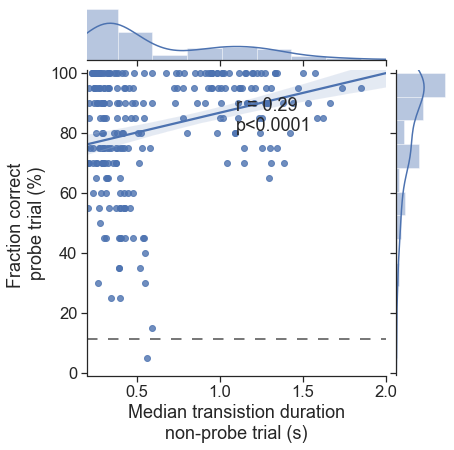

In [68]:
seaborn.jointplot(all_lats,np.array(all_fc)*100,kind='reg')
plt.axhline(y=100/9.,dashes=(7,7),color='.3')
plt.gca().annotate("r = {:.2f} \np<0.0001".format(r),(.5,.8),xycoords='axes fraction')
plt.xlabel("Median transistion duration\nnon-probe trial (s)")
plt.ylabel("Fraction correct \nprobe trial (%)")
plt.ylim(-1,101)
plt.xlim(0.2,2)


In [69]:
#seaborn.distplot(all_fc,kde=0,bins=17)

In [70]:
mu_transs = []
for ijk,k_ in enumerate(allR_dict.keys()):
    for k,v in allR_dict[k_].items():
        #print(k,)
        if len(v)>0:
            #print(len(v))
            v = v[-50:]
            mu_transs.append(stt.binom_test(np.sum(v),len(v),p=1/9.)<0.05)


In [71]:
v

[]

[0.968 0.984 0.988 0.984]


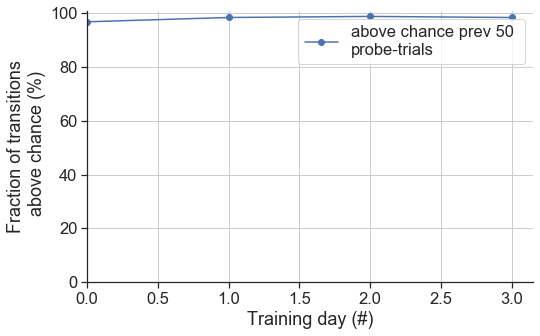

In [72]:
plt.figure(figsize=(8,5))

normC = len(mu_transs)#450 if 'cohort_1' in ROOT else 158

plt.plot(100*np.array(frac_not_yet)/normC,marker='o',label='above chance prev 50 \nprobe-trials')
ax = plt.gca()
#ax2 = plt.gca().twinx()
#ax.plot(100*np.array(frac_not_yet2)/400.,marker='o',color=clrs[1],label='>50 probe trials')
ax.set_ylabel("Fraction of transitions\n above chance (%)")
ax.set_xlabel("Training day (#)")
plt.xlim(0)
plt.ylim(0,101)
plt.legend()
print(np.array(frac_not_yet[-5:])/normC)
plt.grid()
seaborn.despine(top=True)

[0.968 0.984 0.988 0.984]


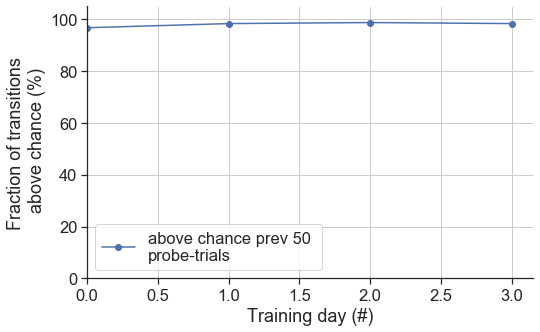

In [73]:
plt.figure(figsize=(8,5))

normC = len(mu_transs)#450 if 'cohort_1' in ROOT else 158

plt.plot(100*np.array(frac_not_yet)/normC,marker='o',label='above chance prev 50 \nprobe-trials')
ax = plt.gca()
#ax2 = plt.gca().twinx()
#ax.plot(100*np.array(frac_not_yet2)/400.,marker='o',color=clrs[1],label='>50 probe trials')
ax.set_ylabel("Fraction of transitions\n above chance (%)")
ax.set_xlabel("Training day (#)")
plt.xlim(0)
plt.ylim(0,105)
plt.legend()
print(np.array(frac_not_yet[-5:])/normC)
plt.grid()
seaborn.despine(top=True)

In [74]:
mu_transs = []
for ijk,k_ in enumerate(allR_dict.keys()):

    for k,v in allR_dict[k_].items():
        #print(k,)
        if len(v)>0:
            mu_transs.append(np.mean(v)>.2)


In [75]:
len(mu_transs)

250

In [76]:
def probe_trial_outcomes(dat_dict,bin_mult=1000,window_s=1.,t_dict=None):
    """ In this notebook track the outcome of probe trials"""
    
    if t_dict is None: tdict = get_empty_transition_dict()

    
    probe_ixs = np.where(np.array([i[-1] for i in dat_dict['port']]))[0]
    
    
    for ix in probe_ixs:
        
        
        probeT = int(dat_dict['port'][ix][-2]*bin_mult) #timestamp of probe trial

        prevPk = dat_dict['port'][ix][0]; target = dat_dict['port'][ix][1]
        
        t_str = str(prevPk) + str(target)


        #these are pokes in window before light comes on
        inprobe_ixs = np.where((inPoke_t>probeT) *(inPoke_t<(probeT+(window_s*bin_mult))))[0]# *

        
        if len(inprobe_ixs)>0:

            #use2 = [i for i in inPokes[ixs] if i!=prevPk]
            use2 = inPokes[inprobe_ixs]
            if len(use2)>0:

                if target in inPokes[inprobe_ixs]:
                    if target in [0,3,5,8]:
                        poked_correctR.append(1)
                        tdict[t_str].append(1)
                        allR_dict[subject_id][t_str].append(1)
                    else:
                        poked_correctNR.append(1)
                        tdict[t_str].append(1)
                        allR_dict[subject_id][t_str].append(1)
                    poked_correct.append(1)
                else:
                    if target in [0,3,5,8]:
                        poked_correctR.append(0)
                        tdict[t_str].append(0)
                        allR_dict[subject_id][t_str].append(0)
                    else:
                        poked_correctNR.append(0)
                        tdict[t_str].append(0)
                        allR_dict[subject_id][t_str].append(0)
                    poked_correct.append(0)

            else:
                allR_dict[subject_id][t_str].append(0)

            poked_in_probe.append(1)
        else:
            poked_correct.append(0)
            if target in [0,3,5,8]:
                poked_correctR.append(0)
            else:
                poked_correctNR.append(0)

            poked_in_probe.append(0)
            #tdict[t_str].append(0)
            allR_dict[subject_id][t_str].append(0)
            
    return poked_correctR, poked_correctNR, t_dict

In [77]:
fC = []
regs2 = []
mouse_list = np.unique([i[:-2] for i in list(allR_dict.keys())]).tolist()
for ijk,k_ in enumerate(allR_dict.keys()):

    for k,v in allR_dict[k_].items():
        if len(v)>0:

            v = np.array(v)
            
            t1_,t2_ = int(k[0]),int(k[1])
            t1 = np.zeros(9); t1[t1_] = 1
            t2 = np.zeros(9); t2[t2_] = 1
            mReg = np.zeros(18); mReg[mouse_list.index(k_[:-2])-1] = 1
            dst = np.array(poke_pos[t1_])-np.array(poke_pos[t2_])
            isR = [t1_ in [0,3,5,8]]
            #isBelow = [dst[0]<0]
            absDst = np.abs(dst)
            regs2.append(np.hstack([t1,t2,absDst,isR,mReg,[k_[-1]==1]]))
            fC.append([np.sum(v[-50:]),np.sum(v[-50:]==0)])

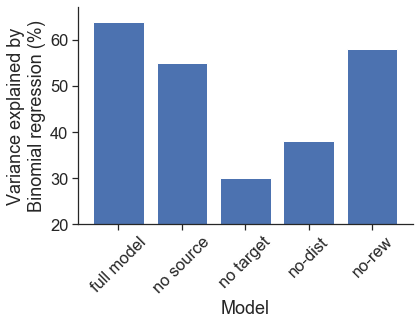

In [78]:
plt.bar(range(5), [64,55,30,38,58])
plt.ylabel("Variance explained by\nBinomial regression (%)")
plt.xticks(range(5),['full model','no source','no target','no-dist','no-rew'],rotation=45)
plt.xlabel("Model")
plt.ylim(20)
seaborn.despine()

In [79]:
fc = []
regs = []
for kk,i in enumerate(fC):
    if np.sum(i)>10:
        fc.append(i)
        regs.append(regs2[kk])

In [80]:
DM = np.vstack([np.hstack(i) for i in regs])
fc = np.array(fc)

In [81]:
import statsmodels.api as sm

glm_binom = sm.GLM(fc,DM, family=sm.families.Binomial())

In [82]:
res = glm_binom.fit()

In [83]:
print('Fraction of explained deviance: {:.2f}%'.format(1-res.llf/res.llnull))

Fraction of explained deviance: 0.48%


In [84]:
print('Fraction of explained deviance: {:.2f}%'.format(1-res.llf/res.llnull))

Fraction of explained deviance: 0.48%


Text(0, 0.5, 'Mean parameter weight')

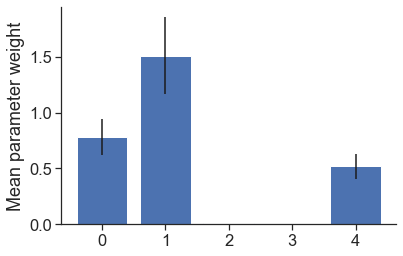

In [85]:
y = [np.mean(np.abs(res.params[:9])),
   np.mean(np.abs(res.params[9:18])),
   np.abs(res.params[18]),
   np.abs(res.params[19]),
   np.mean(np.abs(res.params[19:]))]


yerr = [stt.sem(np.abs(res.params[:9])),
                   stt.sem(np.abs(res.params[9:18])),
                   0,
                   0,
                   stt.sem(np.abs(res.params[19:]))]
plt.bar(range(5),y,yerr=yerr)
#plt.xticks(range(5),['source','target','distance',''],rotation=45)
seaborn.despine()
plt.ylabel("Mean parameter weight")
#plt.

In [86]:
[stt.sem(np.abs(res.params[:9])),
                   stt.sem(np.abs(res.params[9:18])),
                   np.abs(res.params[18]),
                   np.abs(res.params[19]),
                   stt.sem(np.abs(res.params[19:]))]

[0.16138095622819168,
 0.34442581140904727,
 0.00944522334236101,
 0.0019364429338380425,
 0.11255435516514657]

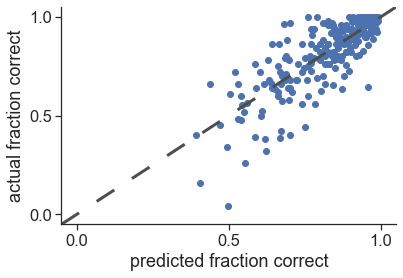

In [87]:
fc_plot = fc[:,0]/np.sum(fc,axis=1)
e = 0.05
plt.scatter(res.mu,fc_plot)
plt.plot([0-e,1+e],[0-e,1+e],color='.3',linewidth=3,dashes=(7,7))
plt.xlim(0-e,1+e)
plt.ylim(0-e,1+e)
seaborn.despine()
plt.xlabel('predicted fraction correct')
plt.ylabel('actual fraction correct')
plt.locator_params(nbins=3)

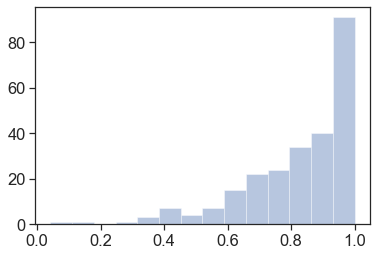

In [88]:
seaborn.distplot(fc[:,0]/np.sum(fc,axis=1),kde=0)

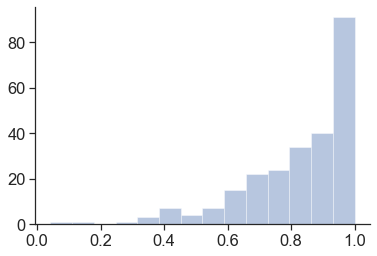

In [89]:
seaborn.distplot(fc[:,0]/np.sum(fc,axis=1),kde=0)
seaborn.despine()

In [90]:
np.mean(fc[:,0]/np.sum(fc,axis=1))

0.8259207612480411

In [91]:
[[np.mean(i[-10:]),j,len(i)] for j,i in allR_dict['459849_None_2'].items() if len(i)>5]

[[0.8, '60', 247],
 [0.6, '82', 121],
 [0.5, '74', 151],
 [0.6, '01', 252],
 [0.9, '13', 114],
 [1.0, '15', 138],
 [1.0, '23', 157],
 [0.8, '36', 235],
 [1.0, '48', 133],
 [0.9, '57', 144]]

In [92]:
    mu_transs = [np.mean(i) for i in allR_dict['459849_3_2'].values() if len(i)>0]


In [93]:
from statsmodels.stats.proportion import proportion_confint

In [94]:
stt.binom_test(15,100,p=0.09)

0.051396053885998313

In [95]:
pairs = []
ctr = 0 
for i,j in zip([i for i in dat_dict['port']],[i for i in dat_dict['state']]):
    #if
    ctr += 1
    if np.abs(i[2] - j[2])<.05:
        if [i[0],j[0]] not in [i[:2] for i in pairs]:
            pairs.append([i[0],j[0]])

In [96]:
len(pairs)

6

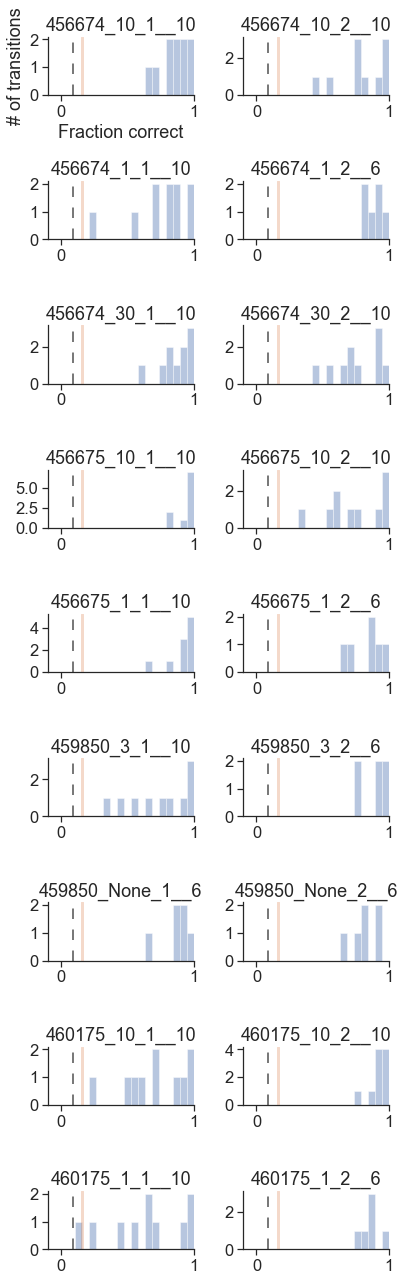

In [460]:
plt.figure(figsize=(6,18))
iii = 0
for ijk,k in enumerate(sorted(allR_dict.keys())):
    if (('None' not in k) and ('33' not in k) and ('3' not in k)) or ('850_3' in k) or ('850_None' in k) or ('30' in k):
        plt.subplot(9,2,iii+1)
        plt.title(k + '__' +str(len([np.mean(i[-5:]) for i in allR_dict[k].values() if len(i)>0])))

        mu_transs = [np.mean(i[-100:]) for i in allR_dict[k].values() if len(i)>0]
        #for k,v in allR_dict[k].items():
        #    #print(k,)
        #    if len(v)>0:
        #        mu_transs.append(np.mean(v[-10:]))

        #print(len(mu_transs))
        seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=20))
        plt.axvline(x=0.09,color='.3',dashes=(7,7))
        plt.axvline(x=0.16,color=clrs[1],alpha=.3,linewidth=3)

        if ijk==0:
            plt.ylabel("# of transitions")
            plt.xlabel("Fraction correct")
        #plt.ylim(0,6)
        plt.xlim(-.1,1)
        plt.locator_params('y',nbins=3)
        iii += 1
plt.tight_layout()
seaborn.despine( )

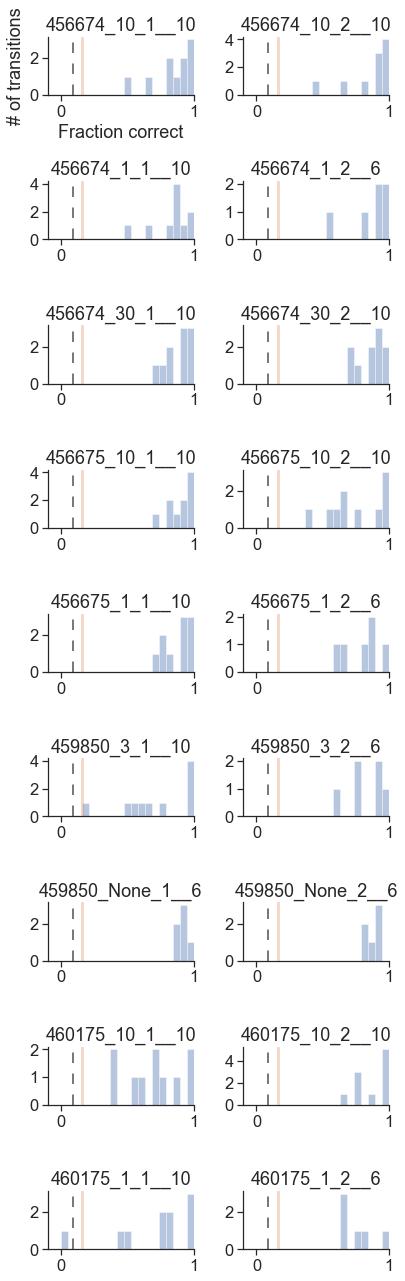

In [97]:
plt.figure(figsize=(6,18))
iii = 0
for ijk,k in enumerate(sorted(allR_dict.keys())):
    if (('None' not in k) and ('33' not in k) and ('3' not in k)) or ('850_3' in k) or ('850_None' in k) or ('30' in k):
        plt.subplot(9,2,iii+1)
        plt.title(k + '__' +str(len([np.mean(i[-5:]) for i in allR_dict[k].values() if len(i)>0])))

        mu_transs = [np.mean(i[-50:]) for i in allR_dict[k].values() if len(i)>0]
        #for k,v in allR_dict[k].items():
        #    #print(k,)
        #    if len(v)>0:
        #        mu_transs.append(np.mean(v[-10:]))

        #print(len(mu_transs))
        seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=20))
        plt.axvline(x=0.09,color='.3',dashes=(7,7))
        plt.axvline(x=0.16,color=clrs[1],alpha=.3,linewidth=3)

        if ijk==0:
            plt.ylabel("# of transitions")
            plt.xlabel("Fraction correct")
        #plt.ylim(0,12)
        plt.xlim(-.1,1)
        plt.locator_params('y',nbins=3)
        iii += 1
plt.tight_layout()
seaborn.despine( )

In [413]:
edges = []
for i in mu_transs:
    edges.append([int(i[0][0]),int(i[0][1])])
    
G0 = nx.DiGraph()
G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
nx.draw(G0,pos=np.array([1,-1])*poke_pos,alpha=.2)
G = nx.DiGraph()
G.add_edges_from([i for i in edges if None not in i])
nx.draw(G,
    pos=np.array([1,-1])*poke_pos,)
#drawn.append(animal+ '__' + task_nr)


IndexError: invalid index to scalar variable.

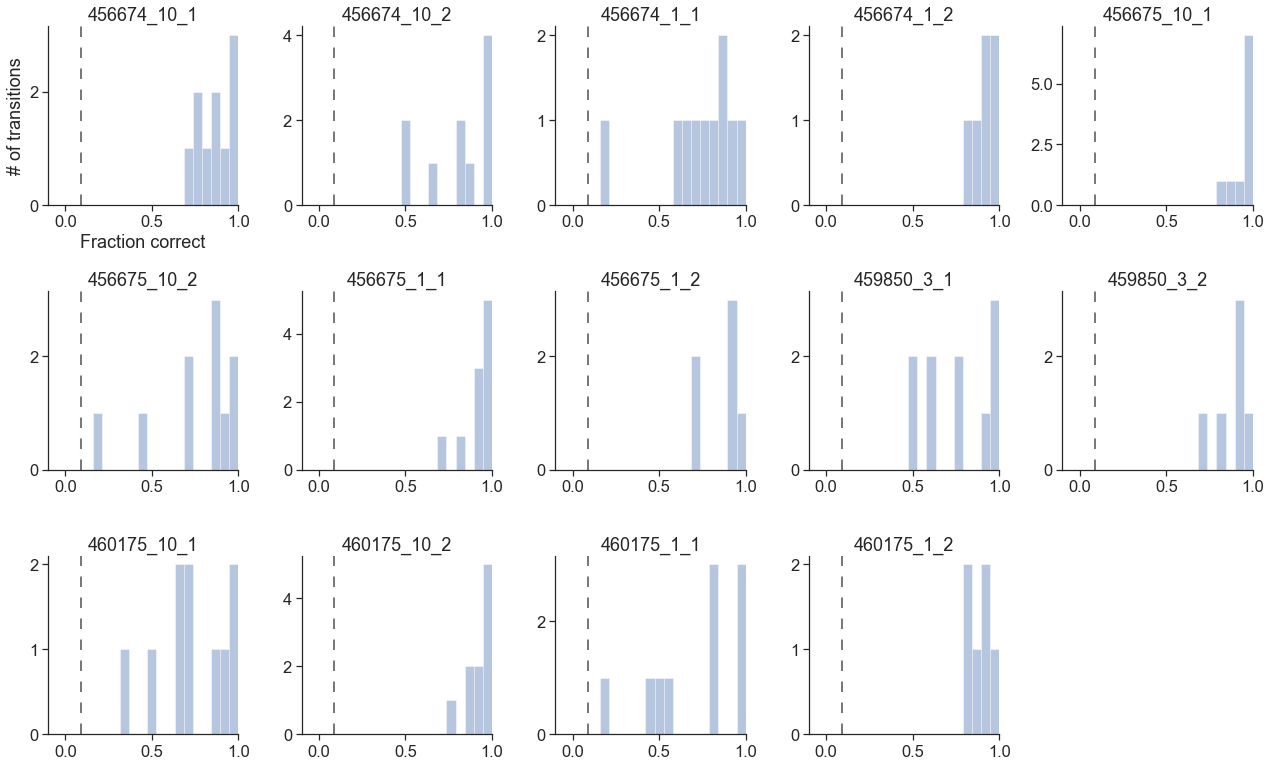

In [414]:
plt.figure(figsize=(18,18))
iii = 0
for ijk,k in enumerate(sorted(allR_dict.keys())):
    if (('None' not in k) and ('33' not in k) and ('3' not in k)) or ('850_3' in k):
        plt.subplot(5,5,iii+1)
        plt.title(k)

        mu_transs = [np.mean(i) for i in allR_dict[k].values() if len(i)>0]
        #for k,v in allR_dict[k].items():
        #    #print(k,)
        #    if len(v)>0:
        #        mu_transs.append(np.mean(v[-10:]))

        #print(len(mu_transs))
        seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=20))
        plt.axvline(x=0.09,color='.3',dashes=(7,7))
        if ijk==0:
            plt.ylabel("# of transitions")
            plt.xlabel("Fraction correct")
        #plt.ylim(0,12)
        plt.xlim(-.1,1)
        plt.locator_params('y',nbins=3)
        iii += 1
plt.tight_layout()
seaborn.despine()

9
9
9
9
10


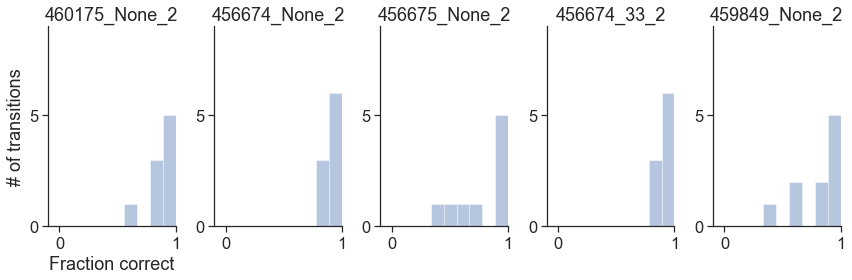

In [52]:
plt.figure(figsize=(12,4))
for ijk,k in enumerate(['460175_None_2','456674_None_2','456675_None_2','456674_33_2','459849_None_2']):
    plt.subplot(1,5,ijk+1)
    plt.title(k)

    mu_transs = [np.mean(i[-50:]) for i in allR_dict[k].values() if len(i)>0]
    print(len(mu_transs))
    #for k,v in allR_dict[k].items():
    #    #print(k,)
    #    if len(v)>0:
    #        mu_transs.append(np.mean(v[-10:]))

    #print(len(mu_transs))
    seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=10))
    if ijk==0:
        plt.ylabel("# of transitions")
        plt.xlabel("Fraction correct")
    #plt.ylim(0,12)
    plt.xlim(-.1,1)
    plt.ylim(0,9)
    plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

16
16
0
16


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


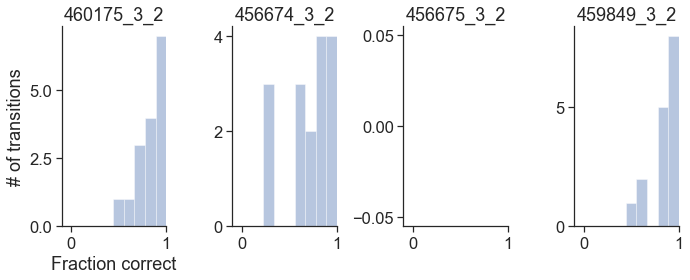

In [53]:
plt.figure(figsize=(12,4))
for ijk,k in enumerate(['460175_3_2','456674_3_2','456675_3_2','459849_3_2']):
    plt.subplot(1,5,ijk+1)
    plt.title(k)

    mu_transs = [np.mean(i[-30:]) for i in allR_dict[k].values() if len(i)>0]
    print(len(mu_transs))
    #for k,v in allR_dict[k].items():
    #    #print(k,)
    #    if len(v)>0:
    #        mu_transs.append(np.mean(v[-10:]))

    #print(len(mu_transs))
    seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=10))
    if ijk==0:
        plt.ylabel("# of transitions")
        plt.xlabel("Fraction correct")
    #plt.ylim(0,12)
    plt.xlim(-.1,1)
    #plt.ylim(0,9)
    plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

In [ ]:
'456675_3_2'

16
16
0
16


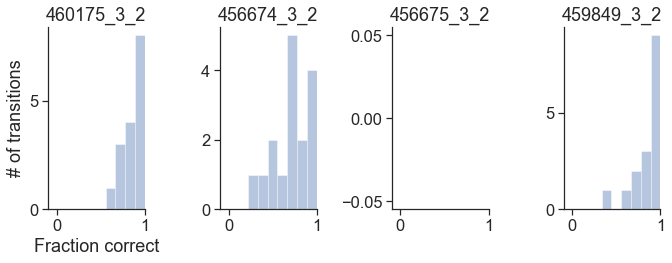

In [157]:
plt.figure(figsize=(12,4))
for ijk,k in enumerate(['460175_3_2','456674_3_2','456675_3_2','459849_3_2']):
    plt.subplot(1,5,ijk+1)
    plt.title(k)

    mu_transs = [np.mean(i[-20:]) for i in allR_dict[k].values() if len(i)>0]
    print(len(mu_transs))
    #for k,v in allR_dict[k].items():
    #    #print(k,)
    #    if len(v)>0:
    #        mu_transs.append(np.mean(v[-10:]))

    #print(len(mu_transs))
    seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=10))
    if ijk==0:
        plt.ylabel("# of transitions")
        plt.xlabel("Fraction correct")
    #plt.ylim(0,12)
    plt.xlim(-.1,1)
    #plt.ylim(0,9)
    plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

16
16
16
16


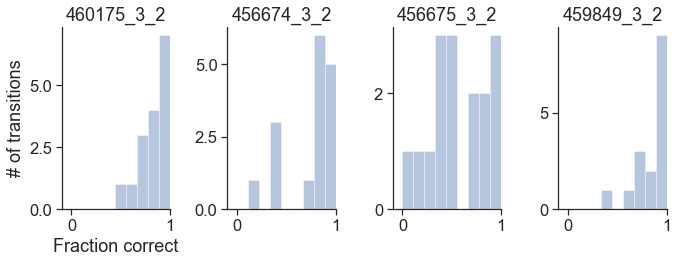

In [3467]:
plt.figure(figsize=(12,4))
for ijk,k in enumerate(['460175_3_2','456674_3_2','456675_3_2','459849_3_2']):
    plt.subplot(1,5,ijk+1)
    plt.title(k)

    mu_transs = [np.mean(i[:]) for i in allR_dict[k].values() if len(i)>0]
    print(len(mu_transs))
    #for k,v in allR_dict[k].items():
    #    #print(k,)
    #    if len(v)>0:
    #        mu_transs.append(np.mean(v[-10:]))

    #print(len(mu_transs))
    seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=10))
    if ijk==0:
        plt.ylabel("# of transitions")
        plt.xlabel("Fraction correct")
    #plt.ylim(0,12)
    plt.xlim(-.1,1)
    #plt.ylim(0,9)
    plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

16
16
16
16


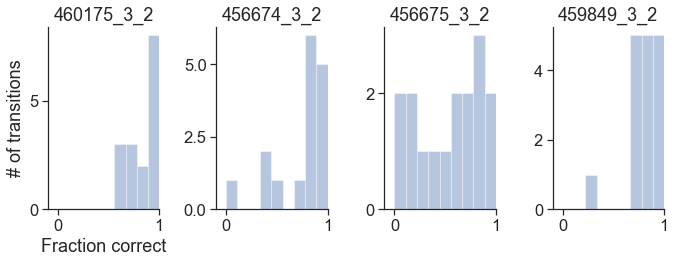

In [3533]:
plt.figure(figsize=(12,4))
for ijk,k in enumerate(['460175_3_2','456674_3_2','456675_3_2','459849_3_2']):
    plt.subplot(1,5,ijk+1)
    plt.title(k)

    mu_transs = [np.mean(i[-200:]) for i in allR_dict[k].values() if len(i)>0]
    print(len(mu_transs))
    #for k,v in allR_dict[k].items():
    #    #print(k,)
    #    if len(v)>0:
    #        mu_transs.append(np.mean(v[-10:]))

    #print(len(mu_transs))
    seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=10))
    if ijk==0:
        plt.ylabel("# of transitions")
        plt.xlabel("Fraction correct")
    #plt.ylim(0,12)
    plt.xlim(-.1,1)
    #plt.ylim(0,9)
    plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

16
16
0
16


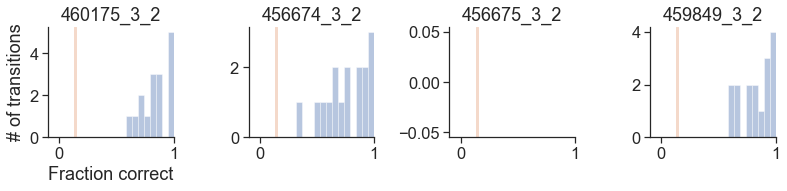

In [317]:
plt.figure(figsize=(14,3))
for ijk,k in enumerate(['460175_3_2','456674_3_2','456675_3_2','459849_3_2']):
    plt.subplot(1,5,ijk+1)
    plt.title(k)

    mu_transs = [np.mean(i[-50:]) for i in allR_dict[k].values() if len(i)>0]
    print(len(mu_transs))
    #for k,v in allR_dict[k].items():
    #    #print(k,)
    #    if len(v)>0:
    #        mu_transs.append(np.mean(v[-10:]))

    #print(len(mu_transs))
    seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=20))
    plt.axvline(x=0.14,color=clrs[1],alpha=.3,linewidth=3)

    if ijk==0:
        plt.ylabel("# of transitions")
        plt.xlabel("Fraction correct")
    #plt.ylim(0,12)
    plt.xlim(-.1,1)
    #plt.ylim(0,9)
    plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

In [2233]:
mu_transs

[0.8125,
 0.6923076923076923,
 0.9166666666666666,
 0.6666666666666666,
 0.9090909090909091,
 0.9523809523809523,
 0.9285714285714286,
 1.0,
 0.8888888888888888]

In [2234]:
[len(i) for i in allR_dict[k].values() if len(i)>0]

[16, 13, 12, 6, 22, 21, 14, 15, 9]

16


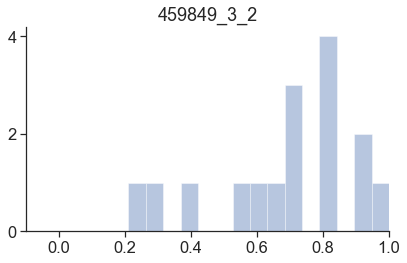

In [2777]:
plt.figure(figsize=(6,4))
k ='459849_3_2'
#for ijk,k in enumerate(['460175_None_2','456674_None_2','456675_None_2','456674_33_2','459849_None_2']):
    #plt.subplot(1,5,ijk+1)
plt.title(k)

mu_transs = [np.mean(i[-50:]) for i in allR_dict[k].values() if len(i)>0]
print(len(mu_transs))
#for k,v in allR_dict[k].items():
#    #print(k,)
#    if len(v)>0:
#        mu_transs.append(np.mean(v[-10:]))

#print(len(mu_transs))
seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=20))
if ijk==0:
    plt.ylabel("# of transitions")
    plt.xlabel("Fraction correct")
#plt.ylim(0,12)
plt.xlim(-.1,1)
#plt.ylim(0,9)
plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

In [1822]:
i

[]

0.9743589743589743
0.9615384615384616
0.75
0.2191780821917808
0.4057971014492754
0.9866666666666667
0.9206349206349206
0.9710144927536232
0.7681159420289855
0.8857142857142857
0.7439024390243902
0.6515151515151515
0.9571428571428572
0.9615384615384616
0.9759036144578314
0.9746835443037974


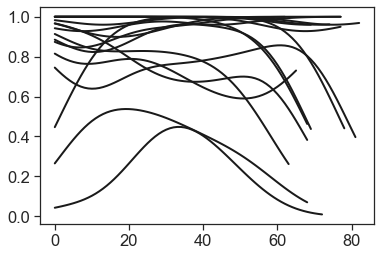

In [1830]:
from scipy.ndimage import gaussian_filter1d
ijk = 0
for i in allR_dict[k].values():
    if len(i)>0:
        #print(i)
        ijk += 1
        oi = i
        print(np.mean(i))
        plt.plot(gaussian_filter1d(np.array(i).astype('float'),10,mode='nearest'),linewidth=2,color='k')

In [1826]:
gaussian_filter1d(oi,5)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

16


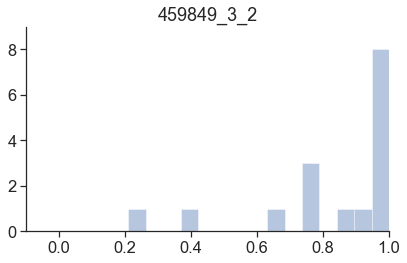

In [1833]:
plt.figure(figsize=(6,4))
k ='459849_3_2'
#for ijk,k in enumerate(['460175_None_2','456674_None_2','456675_None_2','456674_33_2','459849_None_2']):
    #plt.subplot(1,5,ijk+1)
plt.title(k)

mu_transs = [np.mean(i) for i in allR_dict[k].values() if len(i)>0]
print(len(mu_transs))
#for k,v in allR_dict[k].items():
#    #print(k,)
#    if len(v)>0:
#        mu_transs.append(np.mean(v[-10:]))

#print(len(mu_transs))
seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=20))
if ijk==0:
    plt.ylabel("# of transitions")
    plt.xlabel("Fraction correct")
#plt.ylim(0,12)
plt.xlim(-.1,1)
plt.ylim(0,9)
#plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

In [1804]:
mu_transs = [np.mean(i) for i in allR_dict[k].values() if len(i)>0]


In [1805]:
mu_transs

[0.9743589743589743,
 0.9615384615384616,
 0.75,
 0.2191780821917808,
 0.4057971014492754,
 0.9866666666666667,
 0.9206349206349206,
 0.9710144927536232,
 0.7681159420289855,
 0.8857142857142857,
 0.7439024390243902,
 0.6515151515151515,
 0.9571428571428572,
 0.9615384615384616,
 0.9759036144578314,
 0.9746835443037974]

In [1793]:


len(mu_transs)

16

16


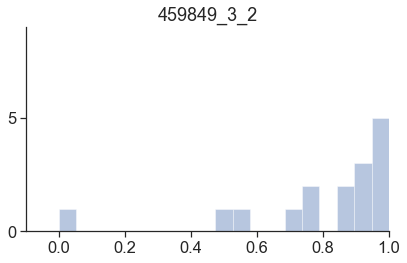

In [1614]:
plt.figure(figsize=(6,4))
k ='459849_3_2'
#for ijk,k in enumerate(['460175_None_2','456674_None_2','456675_None_2','456674_33_2','459849_None_2']):
    #plt.subplot(1,5,ijk+1)
plt.title(k)

mu_transs = [np.mean(i[-20:]) for i in allR_dict[k].values() if len(i)>0]
print(len(mu_transs))
#for k,v in allR_dict[k].items():
#    #print(k,)
#    if len(v)>0:
#        mu_transs.append(np.mean(v[-10:]))

#print(len(mu_transs))
seaborn.distplot(mu_transs,kde=0,bins=np.linspace(0,1,num=20))
if ijk==0:
    plt.ylabel("# of transitions")
    plt.xlabel("Fraction correct")
#plt.ylim(0,12)
plt.xlim(-.1,1)
plt.ylim(0,9)
plt.locator_params('y',nbins=3)
plt.tight_layout()
seaborn.despine()

In [1203]:
np.min(mu_transs)

0.0

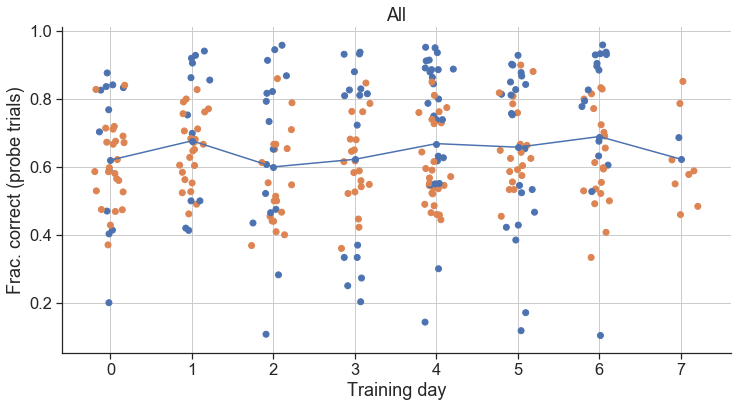

In [1678]:
plt.figure(figsize=(12,6))
plt.title("All")
plt.plot([np.nanmean([np.nanmean(i) for i in allRes[j]['pkA']]) for j in range(len(allRes))],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkA2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkA']],c=np.array([clrs[0] if i=='loop' else clrs[1] for i in allRes[ctr]['graph_type']]))
plt.xlabel("Training day")
plt.ylabel("Frac. correct (probe trials)")
#plt.ylim(.02,1.)
plt.grid()
seaborn.despine()

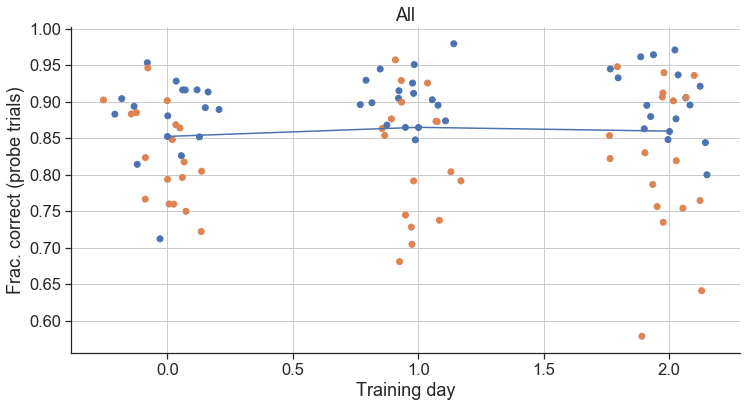

In [417]:
plt.figure(figsize=(12,6))
plt.title("All")
plt.plot([np.nanmean([np.nanmean(i) for i in allRes[j]['pkA']]) for j in range(len(allRes))],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkA2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkA']],c=np.array([clrs[0] if i=='loop' else clrs[1] for i in allRes[ctr]['graph_type']]))
plt.xlabel("Training day")
plt.ylabel("Frac. correct (probe trials)")
#plt.ylim(.02,1.)
plt.grid()
seaborn.despine()

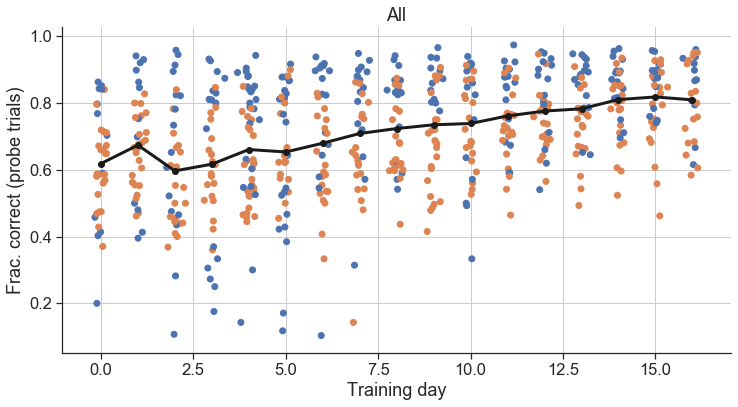

In [3586]:
plt.figure(figsize=(12,6))
plt.title("All")
plt.plot([np.nanmean([np.nanmean(i) for i in allRes[j]['pkA']]) for j in range(len(allRes))],
         marker='o',linewidth=3,color='k')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkA2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkA']],c=np.array([clrs[0] if i=='loop' else clrs[1] for i in allRes[ctr]['graph_type']]))
plt.xlabel("Training day")
plt.ylabel("Frac. correct (probe trials)")
#plt.ylim(.02,1.)
plt.grid()
seaborn.despine()

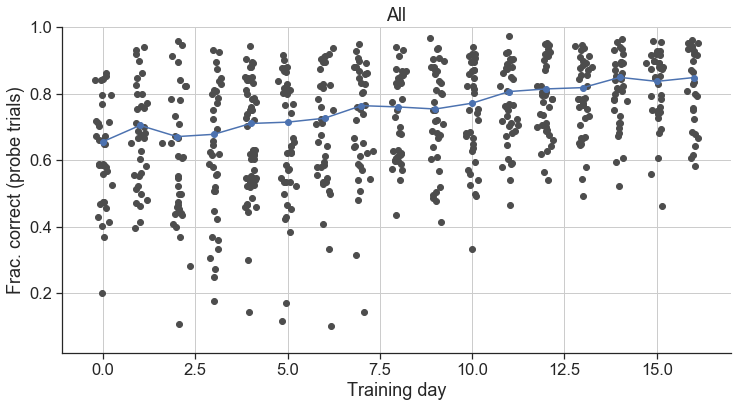

In [3585]:
plt.figure(figsize=(12,6))
plt.title("All")
plt.plot([np.mean(np.hstack(i['pkA'])) for i in allRes],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkA2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkA']],color='.3')
plt.xlabel("Training day")
plt.ylabel("Frac. correct (probe trials)")
plt.ylim(.02,1.)
plt.grid()
seaborn.despine()

In [55]:
len([np.mean(i) for i in allRes[ctr]['pkNR2']])

18

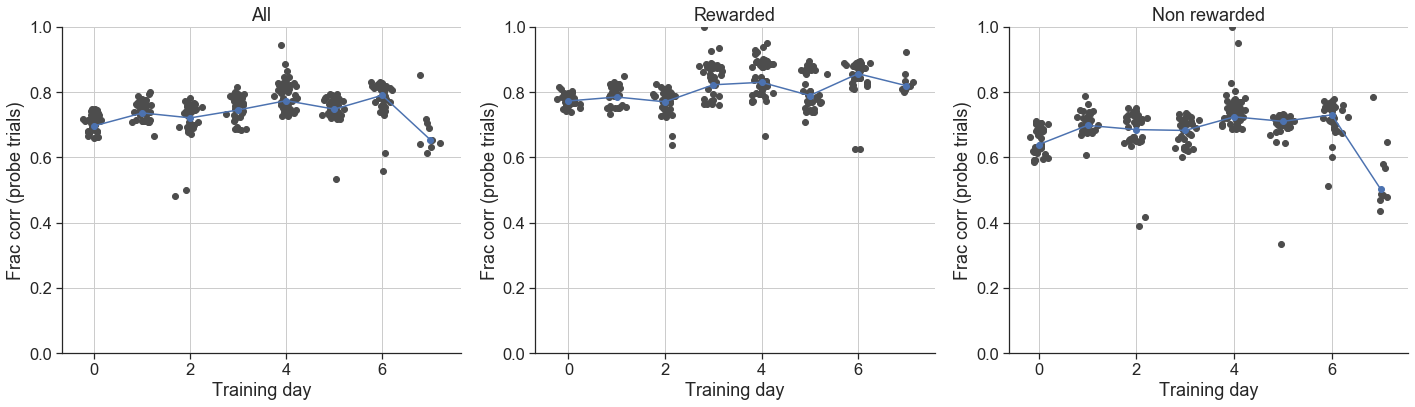

In [1679]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title("All")
plt.plot([np.mean(np.hstack(i['pkA2'])) for i in allRes],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkA2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkA2']],color='.3')
plt.xlabel("Training day")
plt.ylabel("Frac corr (probe trials)")
plt.ylim(0,1.)
plt.grid()


plt.subplot(1,3,2)
plt.title("Rewarded")
plt.plot([np.mean(np.hstack(i['pkR2'])) for i in allRes],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkR2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkR2']],color='.3')
plt.xlabel("Training day")
plt.ylabel("Frac corr (probe trials)")
plt.ylim(0,1.)
plt.grid()


plt.subplot(1,3,3)
plt.title("Non rewarded")
plt.plot([np.mean(np.hstack(i['pkNR2'])) for i in allRes],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkNR2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkNR2']],color='.3')
plt.xlabel("Training day")
plt.ylabel("Frac corr (probe trials)")
plt.ylim(0,1.)
plt.grid()

seaborn.despine()
plt.tight_layout()

In [73]:
len([np.mean(i) for i in allRes[ctr]['pkNR2']])

18

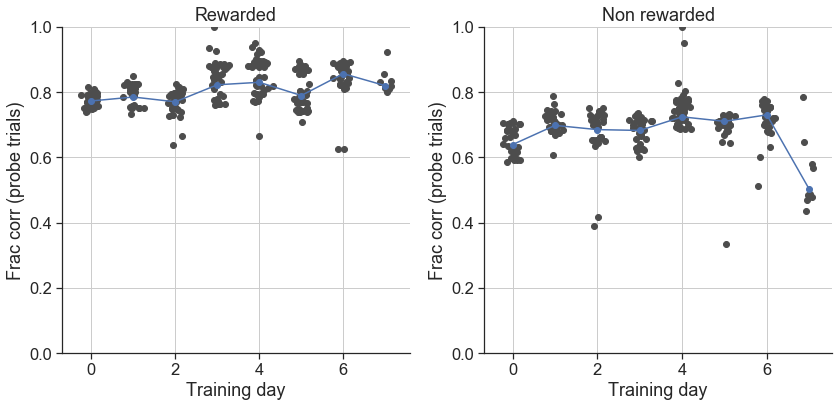

In [1680]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Rewarded")
plt.plot([np.mean(np.hstack(i['pkR2'])) for i in allRes],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkR2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkR2']],color='.3')
plt.xlabel("Training day")
plt.ylabel("Frac corr (probe trials)")
plt.ylim(0,1.)
plt.grid()


plt.subplot(1,2,2)
plt.title("Non rewarded")
plt.plot([np.mean(np.hstack(i['pkNR2'])) for i in allRes],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkNR2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkNR2']],color='.3')
plt.xlabel("Training day")
plt.ylabel("Frac corr (probe trials)")
plt.ylim(0,1.)
plt.grid()

seaborn.despine()
plt.tight_layout()

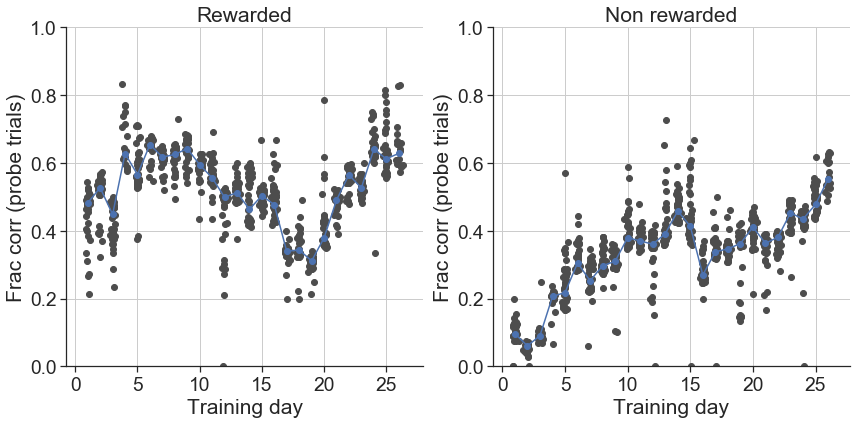

In [410]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Rewarded")
plt.plot([np.mean(np.hstack(i['pkR2'])) for i in allRes],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkR2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkR2']],color='.3')
plt.xlabel("Training day")
plt.ylabel("Frac corr (probe trials)")
plt.ylim(0,1.)
plt.grid()


plt.subplot(1,2,2)
plt.title("Non rewarded")
plt.plot([np.mean(np.hstack(i['pkNR2'])) for i in allRes],marker='o')
for ctr in range(len(allRes)):
    n_ = len(allRes[ctr]['pkNR2'])
    plt.scatter(ctr*np.ones(n_)+np.random.normal(scale=.1,size=n_),
                [np.mean(i) for i in allRes[ctr]['pkNR2']],color='.3')
plt.xlabel("Training day")
plt.ylabel("Frac corr (probe trials)")
plt.ylim(0,1.)
plt.grid()

seaborn.despine()
plt.tight_layout()

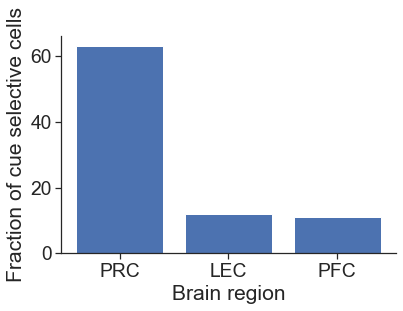

In [175]:
plt.bar(['PRC','LEC','PFC'],[63,12,11])
plt.ylabel("Fraction of cue selective cells")
plt.xlabel("Brain region")
seaborn.despine()

In [177]:
aa1 = np.random.poisson(lam=5,size=100)

In [187]:
aa2 = np.random.normal(size=100)

In [188]:
np.corrcoef(aa1,aa2)

array([[ 1.        , -0.10630941],
       [-0.10630941,  1.        ]])